In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
feature_descriptions = {
    "school":"School",
    "sex":"Sex",
    "age":"Age",
    "address":"Address type",
    "famsize":"Family size",
    "Pstatus":"Parent's cohibition status",
    "Medu":"Mother's education",
    "Fedu":"Father's education",
    "Mjob":"Mother's job",
    "Fjob":"Father's job",
    "reason":"Reason for choosing this school",
    "guardian":"Student's guardian",
    "traveltime":"Home to school travel time",
    "studytime":"Weekly study time",
    "failures":"Number of past class failures",
    "schoolsup":"Extra education support",
    "famsup":"Family eductional support",
    "paid":"Extra paid classes within the subject",
    "activities":"Extra-curricular activities",
    "nursery":"Attended nursery school",
    "higher":"Wants to take higher education",
    "internet":"Has internet at home",
    "romantic":"In a romantic relationship",
    "famrel":"Quality of family relationships (1-5)",
    "freetime":"Amount of free time after school (1-5)",
    "goout":"Frequency of going out with friends (1-5)",
    "Dalc":"Frequency of workday alcohol consumption (1-5)",
    "Walc":"Frequency of workday alcohol consumption (1-5)",
    "health":"Current health status (1-5)",
    "absences":"Number of school absences"
}

file_path = "../tutorials/student/student-por.csv"
data = pd.read_csv(file_path, sep=";")
y = (data["G3"]>10).astype(int)

X_orig = data.drop(["G1", "G2", "G3"], axis='columns')

input_to_explain = X_orig.iloc[0:600]

Local feature contributions - Pyreal

In [3]:
from pyreal.transformers import Transformer, OneHotEncoder, DataFrameWrapper, fit_transformers
from sklearn.preprocessing import StandardScaler
from pyreal.explainers import LocalFeatureContribution

start = time.time()
class BooleanEncoder(Transformer): #****
    def __init__(self, cols, **kwargs): #****
        self.cols = cols #****
        super().__init__(**kwargs) #****
    def data_transform(self, x): #****
        x_transform = x.copy()
        for col in self.cols:
            x_transform[col] = x_transform[col].replace(('yes', 'no'), (1, 0))
        x_transform["famsize"] = x_transform["famsize"].astype('category')
        x_transform["famsize"] = x_transform["famsize"].cat.set_categories(['LE3', 'GT3'])
        x_transform["famsize"] = x_transform["famsize"].cat.reorder_categories(['LE3', 'GT3'])
        x_transform["famsize"] = x_transform["famsize"].cat.codes
        return x_transform #****
    def inverse_transform_explanation(self, explanation): #****
        return explanation #****
onehotencoder = OneHotEncoder(["school", "sex", "address", "Pstatus", "reason", "guardian", "Mjob", "Fjob"])
boolean_encoder = BooleanEncoder(["schoolsup", "famsup", "paid", "activities", "nursery", "internet", "romantic", "higher"])
standard_scaler = DataFrameWrapper(StandardScaler())
transformers = [onehotencoder, boolean_encoder, standard_scaler]
fit_transformers(transformers, X_orig)
lfc = LocalFeatureContribution(model="../tutorials/student/model.pkl",
                               x_train_orig=X_orig, transformers=transformers,
                               feature_descriptions=feature_descriptions,
                               fit_on_init=True)
explanation_pyreal = lfc.produce(input_to_explain)
print("runtime:", time.time()-start)

runtime: 0.07210683822631836


Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


Local feature contributions - No Pyreal

In [4]:
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
import shap
from sklearn.preprocessing import StandardScaler
import pickle

start = time.time()
def boolean_encode(X): #****
    x_transform = X.copy()
    for col in ["schoolsup", "famsup", "paid", "activities", "nursery", "internet", "romantic", "higher"]:
        x_transform[col] = x_transform[col].replace(('yes', 'no'), (1, 0))
    x_transform["famsize"] = x_transform["famsize"].astype('category')
    x_transform["famsize"] = x_transform["famsize"].cat.set_categories(['LE3', 'GT3'])
    x_transform["famsize"] = x_transform["famsize"].cat.reorder_categories(['LE3', 'GT3'])
    x_transform["famsize"] = x_transform["famsize"].cat.codes
    return x_transform #****
X_explain = boolean_encode(X_orig)
columns_to_encode = ["school", "sex", "address", "Pstatus", "reason", "guardian", "Mjob", "Fjob"]
to_encode = X_orig[columns_to_encode]
ohe = SklearnOneHotEncoder(sparse=False).fit(to_encode)
encoded_columns = ohe.get_feature_names(to_encode.columns)
index = to_encode.index
encoded = ohe.transform(to_encode)
encoded = pd.DataFrame(encoded, columns=encoded_columns, index=index)
X_explain = pd.concat([X_explain.drop(columns_to_encode, axis="columns"), encoded], axis=1)
standard_scaler = StandardScaler()
columns = X_explain.columns
index= X_explain.index
X_explain = pd.DataFrame(standard_scaler.fit_transform(X_explain), columns=columns, index=index)
model = pickle.load(open("../tutorials/student/model.pkl", "rb"))
explainer = shap.Explainer(model, X_explain)
explanation = explainer(X_explain[0:600])
explanation_df = pd.DataFrame(explanation.values, columns=columns)
for original_feature in columns_to_encode:
    encoded_features = [item for item in encoded_columns if
                        item.startswith(original_feature + "_")]
    summed_contribution = explanation_df[encoded_features].sum(axis=1)
    explanation_df = explanation_df.drop(encoded_features, axis="columns")
    explanation_df[original_feature] = summed_contribution

explanation_shap = explanation_df.rename(feature_descriptions, axis="columns")
print("runtime:", time.time()-start)

runtime: 0.0648961067199707


Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [5]:
explanation_shap.compare(explanation_pyreal[0])

Empty DataFrame
Columns: []
Index: []

Global feature importance - Pyreal

In [6]:
from pyreal.explainers import GlobalFeatureImportance

start = time.time()
class BooleanEncoder(Transformer): #****
    def __init__(self, cols, **kwargs): #****
        self.cols = cols #****
        super().__init__(**kwargs)
    def data_transform(self, x): #****
        x_transform = x.copy()
        for col in self.cols:
            x_transform[col] = x_transform[col].replace(('yes', 'no'), (1, 0))
        x_transform["famsize"] = x_transform["famsize"].astype('category')
        x_transform["famsize"] = x_transform["famsize"].cat.set_categories(['LE3', 'GT3'])
        x_transform["famsize"] = x_transform["famsize"].cat.reorder_categories(['LE3', 'GT3'])
        x_transform["famsize"] = x_transform["famsize"].cat.codes
        return x_transform #****
    def inverse_transform_explanation(self, explanation): #****
        return explanation #****
onehotencoder = OneHotEncoder(["school", "sex", "address", "Pstatus", "reason", "guardian", "Mjob", "Fjob"])
boolean_encoder = BooleanEncoder(["schoolsup", "famsup", "paid", "activities", "nursery", "internet", "romantic", "higher"])
standard_scaler = DataFrameWrapper(StandardScaler())
transformers = [onehotencoder, boolean_encoder, standard_scaler]
fit_transformers(transformers, X_orig)
lfc = GlobalFeatureImportance(model="../tutorials/student/model.pkl",
                               x_train_orig=X_orig, transformers=transformers,
                               feature_descriptions=feature_descriptions,
                               fit_on_init=True)
explanation_pyreal = lfc.produce()
print("runtime:", time.time()-start)


runtime: 0.08567404747009277


Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


Global feature importance - No Pyreal

In [7]:
start = time.time()
def boolean_encode(X): #****
    x_transform = X.copy()
    for col in ["schoolsup", "famsup", "paid", "activities", "nursery", "internet", "romantic", "higher"]:
        x_transform[col] = x_transform[col].replace(('yes', 'no'), (1, 0))
    x_transform["famsize"] = x_transform["famsize"].astype('category')
    x_transform["famsize"] = x_transform["famsize"].cat.set_categories(['LE3', 'GT3'])
    x_transform["famsize"] = x_transform["famsize"].cat.reorder_categories(['LE3', 'GT3'])
    x_transform["famsize"] = x_transform["famsize"].cat.codes
    return x_transform #****
X_explain = boolean_encode(X_orig)
columns_to_encode = ["school", "sex", "address", "Pstatus", "reason", "guardian", "Mjob", "Fjob"]
to_encode = X_orig[columns_to_encode]
ohe = SklearnOneHotEncoder(sparse=False).fit(to_encode)
encoded_columns = ohe.get_feature_names(to_encode.columns)
index = to_encode.index
encoded = ohe.transform(to_encode)
encoded = pd.DataFrame(encoded, columns=encoded_columns, index=index)
X_explain = pd.concat([X_explain.drop(columns_to_encode, axis="columns"), encoded], axis=1)
standard_scaler = StandardScaler()
columns = X_explain.columns
index= X_explain.index
X_explain = pd.DataFrame(standard_scaler.fit_transform(X_explain), columns=columns, index=index)
model = pickle.load(open("../tutorials/student/model.pkl", "rb"))
explainer = shap.Explainer(model, X_explain)
explanation = explainer(X_explain)
explanation = np.mean(np.absolute(explanation.values), axis=0).reshape(1, -1)
explanation_df = pd.DataFrame(explanation, columns=columns)
for original_feature in columns_to_encode:
    encoded_features = [item for item in encoded_columns if
                        item.startswith(original_feature + "_")]
    summed_contribution = explanation_df[encoded_features].sum(axis=1)
    explanation_df = explanation_df.drop(encoded_features, axis="columns")
    explanation_df[original_feature] = summed_contribution

explanation_shap = explanation_df.rename(feature_descriptions, axis="columns")
print("runtime:", time.time()-start)

runtime: 0.05769610404968262


Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


Decision Tree Explainer - with Pyreal

Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


runtime: 0.08904695510864258


Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


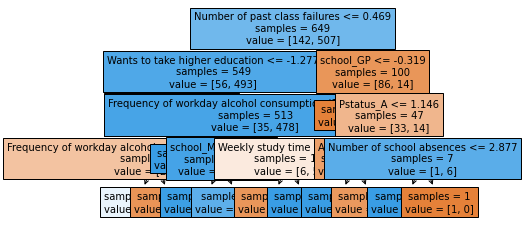

In [8]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from pyreal.explainers import DecisionTreeExplainer

start = time.time()
class BooleanEncoder(Transformer):  # ****
    def __init__(self, cols, **kwargs):  # ****
        self.cols = cols  # ****
        super().__init__(**kwargs) # ****
    def data_transform(self, x):  # ****
        x_transform = x.copy()
        for col in self.cols:
            x_transform[col] = x_transform[col].replace(('yes', 'no'), (1, 0))
        x_transform["famsize"] = x_transform["famsize"].astype('category')
        x_transform["famsize"] = x_transform["famsize"].cat.set_categories(['LE3', 'GT3'])
        x_transform["famsize"] = x_transform["famsize"].cat.reorder_categories(['LE3', 'GT3'])
        x_transform["famsize"] = x_transform["famsize"].cat.codes
        return x_transform  # ****
    def inverse_transform_explanation(self, explanation):  # ****
        return explanation  # ****
onehotencoder = OneHotEncoder(["school", "sex", "address", "Pstatus",
                              "reason", "guardian", "Mjob", "Fjob"])
boolean_encoder = BooleanEncoder(
    ["schoolsup", "famsup", "paid", "activities", "nursery", "internet", "romantic", "higher"])
standard_scaler = DataFrameWrapper(StandardScaler())
transformers = [onehotencoder, boolean_encoder, standard_scaler]
fit_transformers(transformers, X_orig)
dte = DecisionTreeExplainer(model="../tutorials/student/model.pkl",
                            x_train_orig=X_orig, transformers=transformers,
                            is_classifier=True, max_depth=4,
                            feature_descriptions=feature_descriptions,
                            fit_on_init=True)
explanation_pyreal = dte.produce()
print("runtime:", time.time()-start)
plot_tree(explanation_pyreal, feature_names=dte.return_features(),
          impurity=False, fontsize=10, filled=True)
plt.show()


Decision Tree Explainer - No Pyreal

Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


runtime: 0.026254892349243164


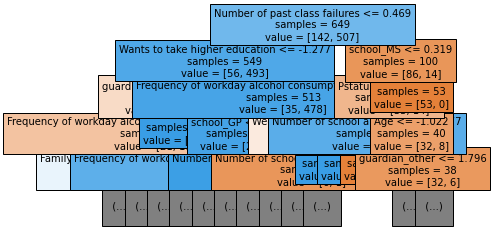

In [9]:
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
import shap
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import pickle

start = time.time()
def boolean_encode(X):  # ****
    x_transform = X.copy()
    for col in ["schoolsup", "famsup", "paid", "activities", "nursery", "internet", "romantic", "higher"]:
        x_transform[col] = x_transform[col].replace(('yes', 'no'), (1, 0))
    x_transform["famsize"] = x_transform["famsize"].astype('category')
    x_transform["famsize"] = x_transform["famsize"].cat.set_categories(['LE3', 'GT3'])
    x_transform["famsize"] = x_transform["famsize"].cat.reorder_categories(['LE3', 'GT3'])
    x_transform["famsize"] = x_transform["famsize"].cat.codes
    return x_transform  # ****
X_explain = boolean_encode(X_orig)
columns_to_encode = ["school", "sex", "address", "Pstatus", "reason", "guardian", "Mjob", "Fjob"]
to_encode = X_orig[columns_to_encode]
ohe = SklearnOneHotEncoder(sparse=False).fit(to_encode)
encoded_columns = ohe.get_feature_names(to_encode.columns)
index = to_encode.index
encoded = ohe.transform(to_encode)
encoded = pd.DataFrame(encoded, columns=encoded_columns, index=index)
X_explain = pd.concat([X_explain.drop(columns_to_encode, axis="columns"), encoded], axis=1)
standard_scaler = StandardScaler()
columns = X_explain.columns
index = X_explain.index
X_explain = pd.DataFrame(standard_scaler.fit_transform(X_explain), columns=columns, index=index)
model = pickle.load(open("../tutorials/student/model.pkl", "rb"))
tree_explainer = tree.DecisionTreeClassifier()
tree_explainer.fit(X_explain, model.predict(X_explain))
print("runtime:", time.time()-start)

plot_tree(tree_explainer, feature_names=dte.return_features(), max_depth=4,
          impurity=False, fontsize=10, filled=True)
plt.show()
